In [74]:
from IPython import display
from utils import Logger
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [75]:
def Fashion_mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])]
         #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        )
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)



# Load data
data = Fashion_mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)  #600*100
num_batches

600

In [76]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),            
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
           
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()


In [77]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            #nn.LeakyReLU(0.2)
            nn.ReLU()
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [78]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [79]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [80]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [81]:
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0002)


In [82]:
def train_discriminator(optimizer, real_data, fake_data):
    
    #clip=0.1, 0.01, 0.001, 0.0001
    clip=0.0001
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    
    prediction_fake = discriminator(fake_data)
    
    loss_D=-torch.mean(prediction_real)+torch.mean( prediction_fake)   
    loss_D.backward()
    optimizer.step()
    
    # Clip weights of discriminator
    for p in discriminator.parameters():
            p.data.clamp_(-clip, clip)

    # Return error and predictions for real and fake inputs
    return loss_D, prediction_real, prediction_fake




In [83]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Adversarial loss
    loss_G = -torch.mean(prediction)
    loss_G.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return loss_G

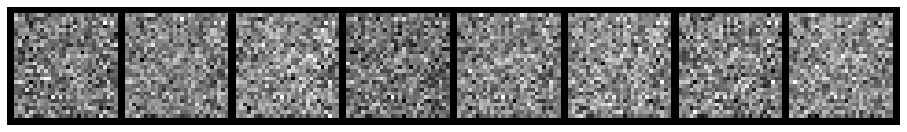

Epoch: [29/30], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: -0.0001
D: 0.0 G: -9.99999901978299e-05
[0.00010553718522714916, -8.461938705295325e-11, 0.0, 0.0, 0.0, 8.48861721654733e-14, 0.0, 8.246085296074549e-13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [-0.00010002997309735899, -0.00010000420086726081, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.999999125284375e-05, -9.99999901978299e-05, -9.999997551252212e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.99999901978299e-05, -9.9

In [84]:
num_test_samples = 8
test_noise = noise(num_test_samples)
logger = Logger(model_name='VGAN', data_name='MNIST')

D_loss=[]
G_loss=[]
N=600
num_epochs=30
for epoch in range(num_epochs):
    LossD=0
    LossG=0
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        LossD+=d_error.item()

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)       
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        LossG+=g_error.item()
        
        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
        # Model Checkpoints
        logger.save_models(generator, discriminator, epoch)
    D_loss.append(LossD/N)
    G_loss.append(LossG/N)
    print('D:',LossD/N,'G:',LossG/N)
print(D_loss,G_loss)  

Text(0, 0.5, 'Training Loss')

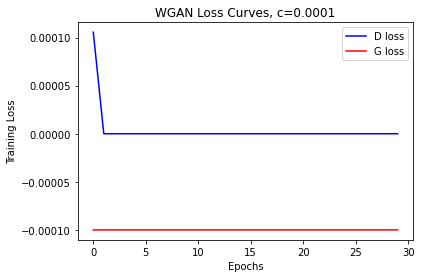

In [85]:
## plot 
plt.title('WGAN Loss Curves, c=0.0001')
plt.plot(D_loss,'b')
plt.plot(G_loss,'r')
#plt.ylim((0.348, 0.356))
plt.legend(['D loss','G loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

In [27]:
PATH="/Users/dl/gen_WGAN"
torch.save(generator.state_dict(),PATH)
print("Succ")


Succ
